In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
! ls "/content/drive/My Drive/dataset"

test  train  validation


In [0]:
import torch
import numpy as np
from torchvision import datasets, models, transforms
import os
import torch.nn as nn
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
directory = '/content/drive/My Drive/dataset'
i_dataset = {x: datasets.ImageFolder(os.path.join(directory, x),data_transforms[x])for x in ['train', 'validation', 'test']}

data_load = {x: torch.utils.data.DataLoader(i_dataset[x], batch_size=64, shuffle=True, num_workers=4)
              for x in ['train', 'validation' ,'test']}

data_size = {x: len(i_dataset[x]) for x in ['train', 'validation','test']}

print({x: len(i_dataset[x]) for x in ['train', 'validation','test']})
class_label = i_dataset['train'].classes
print(class_label)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

{'train': 4000, 'validation': 250, 'test': 250}
['airport_inside', 'bar', 'bedroom', 'casino', 'inside_subway', 'kitchen', 'livingroom', 'restaurant', 'subway', 'warehouse']
cuda:0


# **Part1**

In [0]:
#Create Model
vgg16_model = models.vgg16(pretrained=True) 

#Freeze model weights  
for param in vgg16_model.features.parameters():
    param.requires_grad = False

#Delete fc8 layer
vgg16_model.classifier = nn.Sequential(*list(vgg16_model.classifier.children())[:-2])
#print(vgg16_model)

In [0]:
vgg16_model.eval()
vgg16_model.to(device)

test_x = []            
test_y =[]
   
tr_x = []
tr_y = []
               
with torch.no_grad():
  
    for i, (x,y) in enumerate(data_load['train']):
        x = x.to(device)
        features1 = vgg16_model(x)

        tr_y.extend(y.cpu().numpy())
        tr_x.extend(features1.cpu().numpy())
        
    for i, (a,b) in enumerate(data_load['test']):
        a = a.to(device)
        features2 = vgg16_model(a)

        test_y.extend(b.cpu().numpy())
        test_x.extend(features2.cpu().numpy())


len_test = len(i_dataset["test"].classes) 
correct = np.zeros(len_test)
total = data_size['test']/ len_test

classify = LinearSVC(random_state=0, max_iter=500)
classifier =classify.fit(tr_x, tr_y)

pred_test =classify.predict(test_x)
for i in range(len(pred_test)):
  if(pred_test[i] == test_y[i]):
    correct[pred_test[i]] = correct[pred_test[i]] + 1

result_acc = 100*classify.score(test_x,test_y)
print('Part 1 Average Accuracy : {:.2f}'.format(result_acc))

for i in range(len(correct)):
  correct[i] = 100* correct[i]/total
  print("{} Class Accuracy = {:.2f}%".format(class_label[i], correct[i]))
  

Part 1 Average Accuracy : 84.00
airport_inside Class Accuracy = 72.00%
bar Class Accuracy = 80.00%
bedroom Class Accuracy = 80.00%
casino Class Accuracy = 92.00%
inside_subway Class Accuracy = 96.00%
kitchen Class Accuracy = 84.00%
livingroom Class Accuracy = 64.00%
restaurant Class Accuracy = 80.00%
subway Class Accuracy = 96.00%
warehouse Class Accuracy = 96.00%


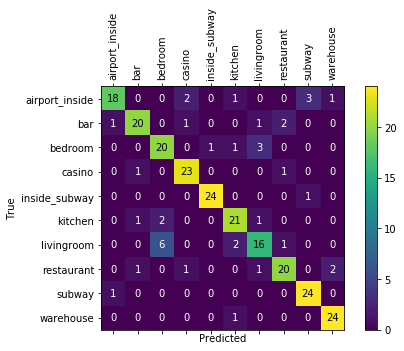

In [0]:
cm = confusion_matrix(test_y, pred_test)
normalize = False
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)

fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="black" if cm[i, j] > thresh else "white")
fig.tight_layout()

tick_marks = np.arange(len(class_label))
plt.xticks(tick_marks,class_label, rotation=90)
plt.yticks(tick_marks,class_label)    
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()